# Init

In [1]:
from __future__ import absolute_import, division, print_function

import logging
import sys

logging.basicConfig(
    stream=sys.stdout,
    level=logging.DEBUG,
    format='%(asctime)s %(name)s-%(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S')
import os
import numpy as np
from modules import utils, feature_extraction as fe, postprocessing, visualization
from modules.data_generation import DataGenerator
import matplotlib.pyplot as plt

logger = logging.getLogger("dataGenNb")


## Generate data 

Data should be in an appropriate format and filtered before when we load it here. It does not have to be scaled. 

In [18]:
dg = DataGenerator(natoms=30, nclusters=4, nframes_per_cluster=500, noise_level=1e-3)
dg.generate_clusters()
feature_to_resids = dg.feature_to_resids()
data, labels = dg.generate_frames()
cluster_indices = labels.argmax(axis=1)
feature_to_resids = None
logger.info("Generated data of shape %s and %s clusters", data.shape, labels.shape[1])

2018-10-30 19:36:12 dataGenNb-INFO: Generated data of shape (2000, 435) and 4 clusters


## Define the different methods to use

Every method is encapsulated in a so called FeatureExtractor class which all follow the same interface

In [19]:
n_iterations, n_splits = 10, 1
feature_extractors = [
    fe.MlpFeatureExtractor(data, labels, n_splits=n_splits, n_iterations=n_iterations),
    fe.ElmFeatureExtractor(data, labels, n_splits=n_splits, n_iterations=n_iterations),
    fe.KLFeatureExtractor(data, labels, n_splits=n_splits, n_iterations=n_iterations),
    fe.PCAFeatureExtractor(data, labels, n_splits=n_splits, n_iterations=n_iterations),
    fe.RandomForestFeatureExtractor(data, labels, n_splits=n_splits, n_iterations=n_iterations),
]
logger.info("Done. using %s feature extractors", len(feature_extractors))


2018-10-30 19:36:12 dataGenNb-INFO: Done. using 5 feature extractors


# Run the relevance analysis

In [23]:
results = []
for extractor in feature_extractors:
    logger.info("Computing relevance for extractors %s", extractor.name)
    feature_importance, std_feature_importance, errors = extractor.extract_features(filter_results=True)
    #logger.info("Get feature_importance and std of shapes %s, %s", feature_importance.shape, std_feature_importance.shape)
    results.append((extractor, feature_importance, std_feature_importance))
logger.info("Done")


2018-10-30 19:37:56 dataGenNb-INFO: Computing relevance for extractors MLP
2018-10-30 19:37:56 Extracting feature-INFO: Using all data in training and validation sets
2018-10-30 19:37:56 Extracting feature-DEBUG: Iteration 1 of 10
2018-10-30 19:37:56 Extracting feature-DEBUG: Error: 0.0
2018-10-30 19:37:56 Extracting feature-DEBUG: Computing feature importance on all data.
2018-10-30 19:37:56 Extracting feature-DEBUG: Iteration 2 of 10
2018-10-30 19:37:56 Extracting feature-DEBUG: Error: 0.0
2018-10-30 19:37:56 Extracting feature-DEBUG: Computing feature importance on all data.
2018-10-30 19:37:56 Extracting feature-DEBUG: Iteration 3 of 10
2018-10-30 19:37:56 Extracting feature-DEBUG: Error: 0.0
2018-10-30 19:37:56 Extracting feature-DEBUG: Computing feature importance on all data.
2018-10-30 19:37:56 Extracting feature-DEBUG: Iteration 4 of 10
2018-10-30 19:37:57 Extracting feature-DEBUG: Error: 0.0
2018-10-30 19:37:57 Extracting feature-DEBUG: Computing feature importance on all dat

2018-10-30 19:38:06 Extracting feature-DEBUG: Computing feature importance on all data.
2018-10-30 19:38:06 PCA featurizer-INFO: Selecting 434 components
2018-10-30 19:38:06 Extracting feature-DEBUG: Iteration 5 of 10
2018-10-30 19:38:06 PCA featurizer-INFO: Training PCA
2018-10-30 19:38:06 Extracting feature-DEBUG: Computing feature importance on all data.
2018-10-30 19:38:06 PCA featurizer-INFO: Selecting 434 components
2018-10-30 19:38:06 Extracting feature-DEBUG: Iteration 6 of 10
2018-10-30 19:38:06 PCA featurizer-INFO: Training PCA
2018-10-30 19:38:06 Extracting feature-DEBUG: Computing feature importance on all data.
2018-10-30 19:38:06 PCA featurizer-INFO: Selecting 434 components
2018-10-30 19:38:06 Extracting feature-DEBUG: Iteration 7 of 10
2018-10-30 19:38:06 PCA featurizer-INFO: Training PCA
2018-10-30 19:38:06 Extracting feature-DEBUG: Computing feature importance on all data.
2018-10-30 19:38:06 PCA featurizer-INFO: Selecting 434 components
2018-10-30 19:38:06 Extracting

# Postprocess results to get average features

In [24]:
postprocessors = []
for (extractor, feature_importance, std_feature_importance) in results:
    p = postprocessing.PostProcessor(extractor, feature_importance, std_feature_importance, cluster_indices,
                                     working_dir=None, feature_to_resids=feature_to_resids)
    p.average()
    postprocessors.append(p)

logger.info("Done")


2018-10-30 19:38:12 postprocessing-DEBUG: Not possible to compute importance per cluster
2018-10-30 19:38:12 postprocessing-DEBUG: Not possible to compute importance per cluster
2018-10-30 19:38:12 dataGenNb-INFO: Done


# Visualize results

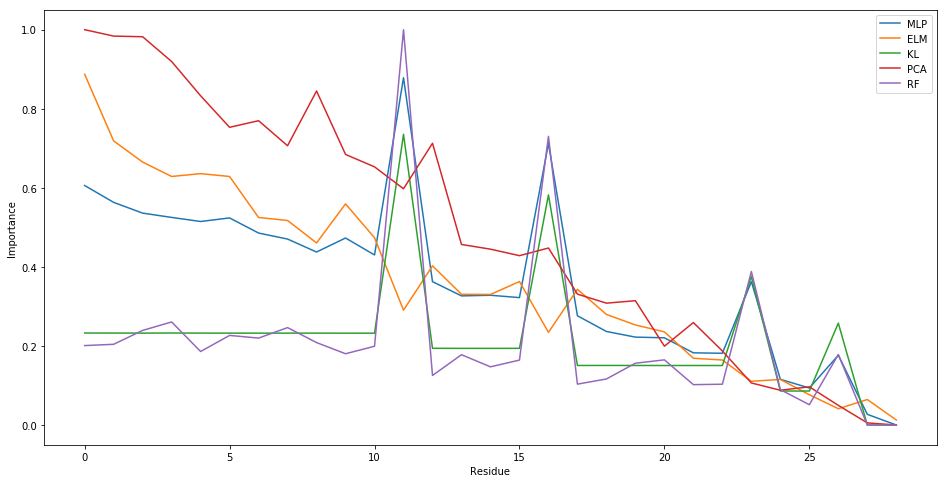

2018-10-30 19:38:13 dataGenNb-INFO: Actual atoms moved: [ 16.  26.  23.  11.]
2018-10-30 19:38:13 dataGenNb-INFO: Done


In [25]:
visualization.visualize(postprocessors)
logger.info("Actual atoms moved: %s", dg.moved_atoms)
logger.info("Done")